# TensorFlow2.0教程-自定义训练（基础）
tensorflow2.0推荐使用tf.keras这样的高级api来构建网络，但tensorflow仍然保持了灵活的构造网络的低级api，我们这节就来介绍怎么通过使用这些低级api构建一个神经网络并训练。




In [1]:
from __future__ import absolute_import, print_function, division, unicode_literals
!pip install -q tensorflow==2.0.0-alpha0
import tensorflow as tf
print(tf.__version__)

2.0.0-alpha0


##  一、Variables
TensorFlow的张量是不可变的无状态对象。当我们有要改变的张量时，可以使用python的特性，把计算得到的值赋给这个python变量。

In [2]:
x = tf.ones([6,6])
x = x + 3 # x+3后得到了一个新的张量，并把这个张量赋给x
print(x)


tf.Tensor(
[[4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4.]], shape=(6, 6), dtype=float32)


然而机器学习中间需要变化的状态（每个参数朝损失变小的方向改变，所以TensorFlow也要内置有状态的操作，这就是Variables，它可以表示模型中的参数，而且方便高效。

Variables是一个存在值的对象，当其被使用是，它被隐式地被从存储中读取，而当有诸如tf.assign_sub, tf.scatter_update这样的操作时，得到的新值会储存到原对象中。




In [3]:
v = tf.Variable(2)
v.assign(6)
print(v)
v.assign_add(tf.square(3))
print(v)

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=6>
<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=15>


注：梯度计算时会自动跟踪变量的计算（不用watch），对表示嵌入的变量，TensorFlow会默认使用稀疏更新，这样可以提高计算和存储效率。

## 二、示例：拟合线性模型

使用Tensor， Variable和GradientTape这些简单的要是，就可以构建一个简单的模型。步骤如下：

- 定义模型
- 定义损失函数
- 获取训练数据
- 模型训练，使用优化器调整变量

在下面我们会构造一个简单的线性模型：f(x) =  W + b,  它有2个变量W和b，同时我们会使用W=3.0，b=2.0来构造数据，用于学习。

###１、定义模型
我们把模型定义为一个简单的类，里面封装了变量和计算

In [10]:
class Model(object):
    def __init__(self):
        # 初始化变量
        self.W = tf.Variable(5.0)
        self.b = tf.Variable(0.0)
    
    def __call__(self, x):
        return self.W * x + self.b
# 测试
model = Model()
print(model(2))

tf.Tensor(10.0, shape=(), dtype=float32)


##２．定义损失函数
损失函数测量给定输入的模型输出与期望输出的匹配程度。 这里使用标准的L2损失。

In [0]:
def loss(predicted_y, true_y):
    return tf.reduce_mean(tf.square(predicted_y - true_y))

## 3.获取训练数据
生成带有噪音的数据

In [0]:
TRUE_W = 3.0
TRUE_b = 2.0
num = 1000

# 随机输入
inputs = tf.random.normal(shape=[num])
# 随机噪音
noise = tf.random.normal(shape=[num])

# 构造数据
outputs = TRUE_W * inputs + TRUE_b + noise


在我们训练模型之前，让我们可以看到模型现在所处的位置。 我们将用红色绘制模型的预测，用蓝色绘制训练数据。

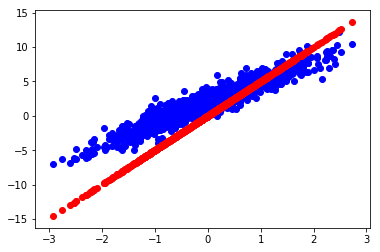

Init Loss:
tf.Tensor(8.763554, shape=(), dtype=float32)


In [13]:
import matplotlib.pyplot as plt

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')
plt.show()

# 当前loss
print('Init Loss:')
print(loss(model(inputs), outputs))

## 4.定义训练循环
我们现在已经有了模型和训练数据。 我们准备开始训练，即使用训练数据来更新模型的变量（W和b），以便使用梯度下降来减少损失。 在tf.train.Optimizer中实现了许多梯度下降方案的变体。 强烈建议大家使用这些实现，但本着从第一原则构建的精神，在这个特定的例子中，我们将自己实现基本的优化器。


In [0]:
def train(model, inputs, outputs, learning_rate):
    # 记录loss计算过程
    with tf.GradientTape() as t:
        current_loss = loss(model(inputs), outputs)
        # 对W，b求导
        dW, db = t.gradient(current_loss, [model.W, model.b])
        # 减去梯度×学习率
        model.W.assign_sub(dW*learning_rate)
        model.b.assign_sub(db*learning_rate)
        

我们反复训练模型，并观察W和b的变化


Epoch  0: W=5.00 b=0.00, loss=8.76355
Epoch  1: W=4.61 b=0.40, loss=5.97410
Epoch  2: W=4.30 b=0.72, loss=4.18118
Epoch  3: W=4.05 b=0.98, loss=3.02875
Epoch  4: W=3.85 b=1.18, loss=2.28800
Epoch  5: W=3.69 b=1.35, loss=1.81184
Epoch  6: W=3.56 b=1.48, loss=1.50577
Epoch  7: W=3.46 b=1.58, loss=1.30901
Epoch  8: W=3.38 b=1.67, loss=1.18253
Epoch  9: W=3.31 b=1.73, loss=1.10123


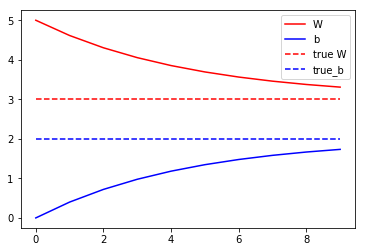

In [19]:
model= Model()

# 收集W，b画图
Ws, bs = [], []
for epoch in range(10):
    Ws.append(model.W.numpy())
    bs.append(model.b.numpy())
    # 计算loss
    current_loss = loss(model(inputs), outputs)
    train(model, inputs, outputs, learning_rate=0.1)
    print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, Ws[-1], bs[-1], current_loss))
# 画图
# Let's plot it all
epochs = range(10)
plt.plot(epochs, Ws, 'r',
         epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'true W', 'true_b'])
plt.show()